In [1]:
# compare the data/mc for cluster shape/position, variables used for BDT training
# to make sure the bdt is not just learning about the difference between data/mc

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2018
category = 0

data_path = '/mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/Data2018/v1/v25/normalized/'
sig_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p16/MC_Fall18/v1/v12/normalized/'
lumi = (5.632467289 +2.572903489 +1.685313225 +3.988453305 +3.068943620 +3.527270568 +8.609721915) * 1000
print("lumi is "+str(round(lumi/1000,2))+" fb-1")
fpath_bkg['mc'] = sig_path+"VH_HToSSTobbbb_ms55_1pb_weighted.root"
fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p15_Data2016_Data2017_Data2018-HighMET_goodLumi.root"
    

lumi is 29.09 fb-1


In [3]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p16/MC_Fall18/v1/v12/normalized/VH_HToSSTobbbb_ms55_1pb_weighted.root
[-0.11291613 -0.08517394 -0.05854289 -0.05795746 -0.03886621 -0.03847754
 -0.03132799 -0.02023848 -0.01858396 -0.01851826 -0.018498    0.018498
  0.01851826  0.01858396  0.02023848  0.03132799  0.03809277  0.03847754
  0.03886621  0.05737788  0.05795746  0.05854289  0.08517394  0.11291613]
(366216,)
data /mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p15/Data2018/v1/v25/normalized/Run2_displacedJetMuonNtupler_V1p15_Data2016_Data2017_Data2018-HighMET_goodLumi.root
[29085.074]
(1886844,)


In [4]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# load BDT

In [23]:
import pandas as pd
import pickle

bdt_model = 2
# if bdt_model == 0:
#     model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1.pickle', "rb" ))
# elif bdt_model == 1:
#     model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs.pickle', "rb" ))
# else:
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v7'
model = pickle.load(open(bdt_name+'.pickle', "rb" ))


In [42]:
%%time

start_t = time.time()
jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
npv = {}
npu = {}
nJets = {}
nJets_50gev = {}
jetPt = {}
jetPhi = {}
jetEta = {}
metPhi = {}
met = {}
jetMet_dPhiMin4 = {}
nJets = {}
jetPhi = {}
jetPt = {}
cscRechitClusterJetPhi = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterZSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaPhiSpread = {}

cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterNStation = {}
cscRechitClusterXYSpread = {}
cscRechitClusterRSpread = {}
cscRechitClusterSize = {}

cscRechitCluster2IsoMuonVetoPt = {}
cscRechitCluster2IsoMuonVetoE = {}
cscRechitCluster2IsoMuonVetoEta = {}
cscRechitClusterTimeSpread = {}
jetMet_dPhiMin = {}
bdt_score = {}

keys = ['mc', 'data']
phi_corr = '0p7'
r_corr = '1p2'
r_corr_flag = 1
highEta = 0
for k in keys:

    T = tree_bkg[k]

    sel_cluster = np.abs(T.array('cscRechitCluster2Time')) < 12.5
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2IsoMuonVetoPt')) > 20)
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2IsoMuonVetoPt')) < 200)
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2IsoMuonVetoEta')) > 1.0)
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2IsoMuonVetoEta'))< 1.2)
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2MaxChamber')) > 12)


    if highEta:
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) >= 1.2)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta'))< 2.1)
    else:
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) >= 1.0)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2Eta')) < 1.2)    
        
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster2TimeSpread'))<20)


    if 'mc' in k:
        sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster2_match_gLLP') == 0)

    print(k, "cluster selection efficiency:", np.count_nonzero(sel_cluster.flatten())/len(sel_cluster.flatten()))
    

# ########### BRANCHES ############
    sel_ev = sel_cluster.sum() ==1 
#     if k == 'data': sel_ev = np.logical_and(sel_ev, T.array('jetMet_dPhiMin')>1)
    
#     if k == 'data': sel_ev = np.logical_and(sel_ev, cscRechitClusterJetPhi[k]>1)
   
    
#     if 'mc' in k:
#         gLLP_decay_vertex_z = T.array('gLLP_decay_vertex_z')
#         gLLP_decay_vertex_r = T.array('gLLP_decay_vertex_r')


#         distance0 = np.sqrt(gLLP_decay_vertex_z[:,0]**2+gLLP_decay_vertex_r[:,0]**2)
#         distance1 = np.sqrt(gLLP_decay_vertex_z[:,1]**2+gLLP_decay_vertex_r[:,1]**2)
#         cond1 = np.logical_or(distance1<200, np.logical_or(gLLP_decay_vertex_z[:,1]>1100, gLLP_decay_vertex_r[:,1]>800))
#         cond0 = np.logical_or(distance0<200, np.logical_or(gLLP_decay_vertex_z[:,0]>1100, gLLP_decay_vertex_r[:,0]>800))
#         sel_ev = np.logical_and(sel_ev, np.logical_and(cond0, cond1))
    print(np.count_nonzero(sel_ev))
    cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterZSpread[k] = T.array('cscRechitCluster2ZSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEtaSpread[k] = T.array('cscRechitCluster2EtaSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterRSpread[k] = T.array('cscRechitCluster2RSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterNStation[k] = T.array('cscRechitCluster2NStation')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread')[sel_cluster][sel_ev][:,0]


    if k == 'mc':
        if r_corr_flag:
            cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterEtaSpread[k] = T.array('cscRechitCluster2EtaSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterRSpread[k] = T.array('cscRechitCluster2RSpread_phi'+phi_corr+'_r'+r_corr)[sel_cluster][sel_ev][:,0]
        else:
            cscRechitClusterXSpread[k] = T.array('cscRechitCluster2XSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterYSpread[k] = T.array('cscRechitCluster2YSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterXYSpread[k] = T.array('cscRechitCluster2XYSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitCluster2EtaPhiSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]
            cscRechitClusterPhiSpread[k] = T.array('cscRechitCluster2PhiSpread_phi'+phi_corr)[sel_cluster][sel_ev][:,0]

    cscRechitClusterX[k] = T.array('cscRechitCluster2X')[sel_cluster][sel_ev][:,0]
    cscRechitClusterY[k] = T.array('cscRechitCluster2Y')[sel_cluster][sel_ev][:,0]
    cscRechitClusterZ[k] = T.array('cscRechitCluster2Z')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEta[k] = T.array('cscRechitCluster2Eta')[sel_cluster][sel_ev][:,0]
    cscRechitClusterPhi[k] = T.array('cscRechitCluster2Phi')[sel_cluster][sel_ev][:,0]
    cscRechitClusterSize[k] = T.array('cscRechitCluster2Size')[sel_cluster][sel_ev][:,0]
    cscRechitClusterTimeSpread[k] = T.array('cscRechitCluster2TimeSpread')[sel_cluster][sel_ev][:,0]

    cscRechitCluster2IsoMuonVetoPt[k] = T.array('cscRechitCluster2IsoMuonVetoPt')[sel_cluster][sel_ev][:,0]
    cscRechitCluster2IsoMuonVetoE[k] = T.array('cscRechitCluster2IsoMuonVetoE')[sel_cluster][sel_ev][:,0]
    cscRechitCluster2IsoMuonVetoEta[k] = T.array('cscRechitCluster2IsoMuonVetoEta')[sel_cluster][sel_ev][:,0]


   ##### cluster-level variables ##### 
#     if bdt_model == 0:
        
#         bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
#          'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
#          'cscRechitClusterNStation':cscRechitClusterNStation[k],
#          'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
#          'cscRechitClusterX':cscRechitClusterX[k],
#          'cscRechitClusterY':cscRechitClusterY[k],
#          'cscRechitClusterZ':cscRechitClusterZ[k],
#         }
#     elif bdt_model == 1:
#         bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
#          'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
#          'cscRechitClusterNStation':cscRechitClusterNStation[k],
#          'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
#          'cscRechitClusterX':np.abs(cscRechitClusterX[k]),
#          'cscRechitClusterY':np.abs(cscRechitClusterY[k]),
#          'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
#         }
    if 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread' in bdt_name:
        bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
        'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
        'cscRechitClusterYSpread':cscRechitClusterYSpread[k],
        'cscRechitClusterXYSpread':cscRechitClusterXYSpread[k],
        'cscRechitClusterPhi':np.abs(cscRechitClusterPhi[k]),
        'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
        'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        }
    else:
        print('BDT NOT FOUND')


##### bdt variables ####
 
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
    print(len(bdt_score[k]) == np.count_nonzero(sel_ev))
    print(np.count_nonzero(bdt_score[k]<0.1))
    met[k] = T.array('met') [sel_ev]
    metPhi[k] = T.array('metPhi')[sel_ev]
    npv[k] = T.array('npv')[sel_ev]
    weight[k] = T.array('weight')[sel_ev]*lumi
    pileupWeight[k] = T.array('pileupWeight')[sel_ev]
    jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev]
    nJets[k] = T.array('nJets')[sel_ev]
    jetPhi[k] = T.array('jetPhi')[sel_ev]
    jetPt[k] = T.array('jetPt')[sel_ev]
    
    cscRechitClusterJetPhi[k] = []
    for ev in range(len(nJets[k])):
        temp_max = 99;
        for jPhi in jetPhi[k][ev]:
            temp_max = min(abs(deltaPhi(jPhi, cscRechitClusterPhi[k][ev])), temp_max)
        cscRechitClusterJetPhi[k].append(temp_max)
    cscRechitClusterJetPhi[k] = np.array(cscRechitClusterJetPhi[k])
    
    if k == 'data':
        pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
        weight[k] = weight[k] * 0.0 + 1.0
#         print(cscRechitClusterXSpread[k][bdt_score[k]<0.1])
#         print(cscRechitClusterYSpread[k][bdt_score[k]<0.1])
#         print(cscRechitClusterXYSpread[k][bdt_score[k]<0.1])
#         print(cscRechitClusterPhi[k][bdt_score[k]<0.1])
#         print(cscRechitClusterEta[k][bdt_score[k]<0.1])
        print(jetMet_dPhiMin[k][bdt_score[k]<0.1])

mc cluster selection efficiency: 0.0019239668423805883
765
True
6
data cluster selection efficiency: 0.0006381694570693072
1272
True
71
[3.1376617  0.82604736 2.7005868  1.3311374  3.0192118  0.93747854
 1.9216348  1.8150973  2.6122687  2.9583676  0.21240199 0.18854117
 2.0483742  2.6437342  2.8248694  0.03789189 0.13126081 0.21079272
 1.579973   2.629519   0.0625065  0.15405405 3.120362   0.14965725
 2.333803   0.27392402 2.60579    3.1217556  0.07243586 1.0774033
 3.0163858  0.35870665 2.6564627  0.05025804 2.836911   0.581213
 2.2652295  0.1584549  2.7428863  0.30005527 2.915561   1.070992
 2.9207582  3.0377076  3.0042686  0.13659692 0.04585338 3.06041
 0.19518578 0.14546466 0.13465613 0.93561053 0.4255091  1.5433073
 1.2582109  1.967373   2.946951   0.04825908 0.11701262 3.0907109
 0.2662983  2.5906277  1.4023349  3.0426202  2.6104245  0.0500145
 0.20693755 0.22115119 0.43247965 0.59666675 2.9064913 ]
CPU times: user 11.1 s, sys: 700 ms, total: 11.8 s
Wall time: 11.5 s


In [40]:
print(np.array(cscRechitClusterJetPhi[k])[bdt_score[k]<0.1])

[2.71459198 0.01117784 2.44914705 1.79721105 2.62960512 0.2198922
 0.99470258 1.83322698 2.07277536 1.39894164 0.06435549 0.15391028
 2.18317747 0.87295568 3.03766894 0.00599626 0.02251095 0.33107531
 1.48480916 2.84083652 0.6742208  0.1952275  2.87393147 0.02313447
 2.46751267 0.02335    0.23032451 2.94419408 0.40325999 0.8723619
 2.74013216 0.17867547 2.29751968 0.07232881 3.13429648 1.12546849
 2.04060578 0.02313066 0.58733279 0.02363753 2.93976712 0.86600786
 3.01095277 2.8601284  0.85478747 0.06984305 3.06806445 3.12994695
 0.10174388 0.64177108 0.0661459  0.31772387 0.84530485 1.31207681
 1.81107473 0.12184149 0.03391922 0.01101637 0.03863299 2.99073553
 0.00380123 2.37129807 1.31361801 2.94351989 2.60366797 0.06611919
 0.30801976 0.01884618 0.15063022 0.60688382 2.91260845]


# with ratio plot

reweight cscRechitCluster2IsoMuonVetoE plot bdt_score


Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


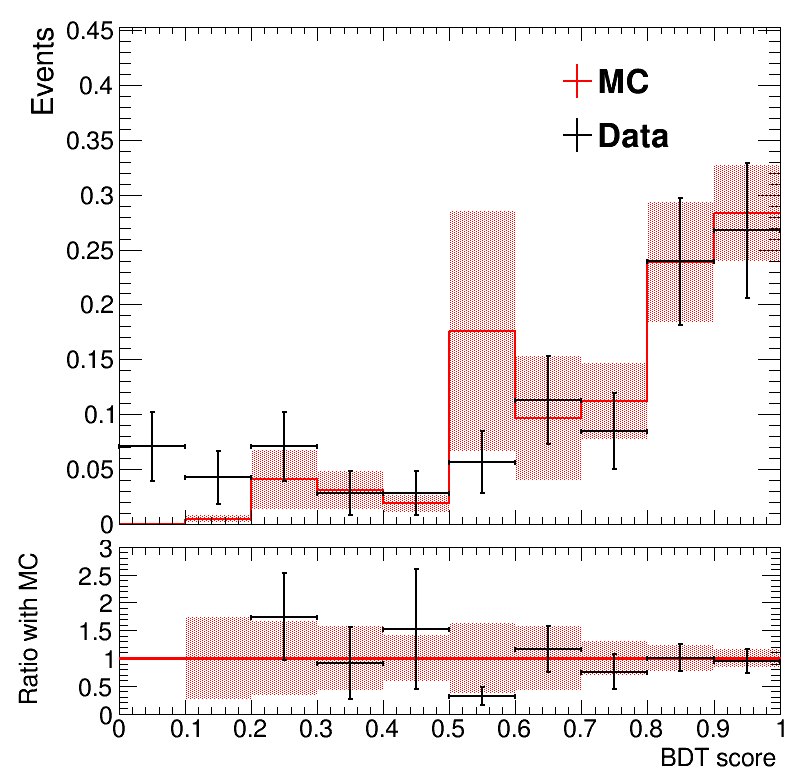

In [47]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
import os

# Plotting ncsc
start_t = time.time()
reweight_flag =1
logy = 0

rt.gStyle.SetOptFit(1011)
if highEta:
    dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_XYspread_'+bdt_name[-2:]+'_muonShower_highEta/'
else:
    dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_XYspread_'+bdt_name[-2:]+'_muonShower_lowEta/'


if not os.path.isdir(dir_name):os.makedirs(dir_name)
var = [jetMet_dPhiMin, cscRechitClusterSize, bdt_score, cscRechitClusterEta, cscRechitClusterPhi, cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, \
   cscRechitClusterEtaSpread, cscRechitClusterPhiSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterRSpread, cscRechitClusterXSpread, cscRechitClusterYSpread, cscRechitClusterZSpread, \
       cscRechitClusterTimeSpread, cscRechitClusterXYSpread, cscRechitClusterNStation, cscRechitCluster2IsoMuonVetoPt, cscRechitCluster2IsoMuonVetoE, cscRechitCluster2IsoMuonVetoEta]
title = ['jetMet_dPhiMin','N_{rechits}', 'BDT score', 'cluster #eta', 'cluster #phi', 'cluster X [cm]','cluster Y [cm]','cluster Z [cm]', \
         'cluster #eta spread', 'cluster #phi spread', 'cluster #eta-#phi spread', 'cluster R-spread [cm]', 'cluster X-spread [cm]','cluster Y-spread [cm]','cluster Z-spread [cm]',\
          'cluster time spread [ns]', 'cluster XY-spread [cm]','N_{station}', 'matched muon pT [GeV]', 'matched muon E [GeV]', 'matched muon #eta']
if highEta:
    bins = [[10,0,3.2], [0, 50, 70, 100, 150, 250, 500], [10,0,1], [10,1,2.1],[10,0,3.2],[15,0,700],[15,0,700], [25,600,1100], 
        [25,0,0.2], [25,0,0.1],[25,0,0.1], [10,0,100], [20,0,100], [20,0,100], [20,0,100],
       [25,0,50],[20,0,60],[5,0,5], [10,0,500], [10,0,500], [25,0.8,1.6]]
else:
    bins = [[10,0,3.2], [0, 50, 70, 100, 150, 250, 500], [10,0,1], [10,1,1.2],[10,0,3.2],[15,0,700],[15,0,700], [25,600,1100], 
        [25,0,0.2], [25,0,0.1],[25,0,0.1], [10,0,100], [20,0,100], [20,0,100], [20,0,100],
       [25,0,50],[20,0,60],[5,0,5], [10,0,500], [10,0,500], [25,0.8,1.6]]

names = ['jetMet_dPhiMin', 'cscRechitClusterSize', 'bdt_score', 'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', \
   'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterRSpread', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', \
       'cscRechitClusterTimeSpread', 'cscRechitClusterXYSpread', 'cscRechitClusterNStation', 'cscRechitCluster2IsoMuonVetoPt', 'cscRechitCluster2IsoMuonVetoE', 'cscRechitCluster2IsoMuonVetoEta']
key_plot = ['data', 'mc']


for j,v in enumerate(var):
    if not j == 2:continue
    leg = rt.TLegend(0.55,0.80,0.87,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    ###########
    # reweight
    ##########
    h = {}
    reweight_index = 19
    print("reweight",names[reweight_index], "plot", names[j])
    h['mc_reweight'] = create_TH1D( np.abs(var[reweight_index]['mc']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = pileupWeight['mc']* weight['mc'])
    h['data_reweight'] = create_TH1D( np.abs(var[reweight_index]['data']), axis_title=[title[reweight_index], 'Events'], name=k, binning=bins[reweight_index], weights = pileupWeight['data']* weight['data'])
    h['data_reweight'].Divide(h['mc_reweight'])
    reweight = []
    for m in range(len(v['mc'])):
        reweight.append(h['data_reweight'].GetBinContent(h['data_reweight'].GetXaxis().FindFixBin(np.abs(var[reweight_index]['mc'])[m])))
    
    maximum = 0
    for i,k in enumerate(key_plot):
        total_weight = pileupWeight[k]* weight[k]
        if k == 'mc' and reweight_flag: total_weight = total_weight * reweight
        cond = cscRechitClusterJetPhi[k]>3
        h[k] = create_TH1D( np.abs(v[k][cond]), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = total_weight[cond])
        h[k].SetLineColor(std_color_list[i])
        maximum = max(maximum, h[k].GetMaximum())
        if logy: h[k].SetMaximum(maximum*10)
        else: h[k].SetMaximum(maximum*10)
    #     h[str(i)].SetMinimum(0.1)
        if 'signal' in k: h[k].SetLineStyle(2)
        h[k].GetXaxis().SetLabelSize(0.04)
#         h[k].DrawNormalized('same hist')
#         if names[j] == 'bdt_score': print('bdt efficiency', k, np.count_nonzero(v[k]>bdt_cut)/len(v[k]))
        h[k].Scale(1./h[k].Integral())
    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=logy, in_tags = ["MC","Data"], ratio_bounds = [0,3], draw_opt = ['E2','E1'])
#     c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=logy, errors = [], in_tags = ["MC","Data"], ratio_bounds = [0,3], draw_opt = ['hist E1','E1'])
#     for index in range(h[key_plot[1]].GetXaxis().GetNbins()):
#         if h[key_plot[1]].GetBinContent(index+1) == 0:
#             print(index, 0.0)
#         else:
#             print(index, h[key_plot[1]].GetBinContent(index+1), h[key_plot[1]].GetBinError(index+1), h[key_plot[1]].GetBinError(index+1)/h[key_plot[1]].GetBinContent(index+1))
    c.SetRightMargin(0.2)
    if logy: c.SetLogy()

    c.Draw()
#     if reweight_flag:
#         if r_corr_flag: c.SaveAs(dir_name+names[j]+"_withRatio_"+names[reweight_index]+"Reweight_phi"+phi_corr+"_r"+r_corr+".png")
#         else: c.SaveAs(dir_name+names[j]+"_withRatio_"+names[reweight_index]+"Reweight_phi"+phi_corr+".png")


#     else:
#         if r_corr_flag:  c.SaveAs(dir_name+names[j]+"_withRatio_phi"+phi_corr+"_r"+r_corr+".png")
#         else:c.SaveAs(dir_name+names[j]+"_withRatio_phi"+phi_corr+".png")



